In [1]:
#라이브러리 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from retentioneering.eventstream import Eventstream

In [2]:
# 데이터 불러오기

click_df = pd.read_csv('./click_stream_new.csv')
click_df.head()

session_id   event_name  \
0  fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c     HOMEPAGE   
1  fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c       SCROLL   
2  7d440441-e67a-4d36-b324-80ffd636d166     HOMEPAGE   
3  7d440441-e67a-4d36-b324-80ffd636d166  ADD_TO_CART   
4  7d440441-e67a-4d36-b324-80ffd636d166      BOOKING   

                    event_time                              event_id  \
0  2019-09-06T15:54:32.821085Z  9c4388c4-c95b-4678-b5ca-e9cbc0734109   
1  2019-09-06T16:03:57.821085Z  4690e1f5-3f99-42d3-84a5-22c4c4d8500a   
2  2019-09-01T12:05:10.322763Z  88aeaeb5-ec98-4859-852c-8abb483faf31   
3  2019-09-01T12:06:33.322763Z  934e306e-ecc6-472f-9ccb-12c8536910a2   
4  2019-09-01T12:15:29.425431Z  9f4767a1-40fa-4c9c-9524-dfad18634d56   

  traffic_source  product_id  quantity  item_price payment_status  \
0         MOBILE         NaN       NaN         NaN            NaN   
1         MOBILE         NaN       NaN         NaN            NaN   
2         MOBILE         NaN       NaN         NaN            NaN   
3         MOBILE     15315.0       4.0    313529.0            NaN   
4         MOBILE         NaN       NaN         NaN        Success   

  search_keywords promo_code  promo_amount  
0             NaN        NaN           NaN  
1             NaN        NaN           NaN  
2             NaN        NaN           NaN  
3             NaN        NaN           NaN  
4             NaN        NaN           NaN

In [3]:
# 데이터 마스킹

click_df = click_df[click_df['traffic_source'] == 'MOBILE']
click_df = click_df[click_df['event_name'] != 'CLICK']
click_df = click_df[click_df['event_name'] != 'SCROLL']
click_df = click_df[['session_id', 'event_name', 'event_time']]
click_df.head()

session_id   event_name  \
0  fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c     HOMEPAGE   
2  7d440441-e67a-4d36-b324-80ffd636d166     HOMEPAGE   
3  7d440441-e67a-4d36-b324-80ffd636d166  ADD_TO_CART   
4  7d440441-e67a-4d36-b324-80ffd636d166      BOOKING   
5  7d440441-e67a-4d36-b324-80ffd636d166       SEARCH   

                    event_time  
0  2019-09-06T15:54:32.821085Z  
2  2019-09-01T12:05:10.322763Z  
3  2019-09-01T12:06:33.322763Z  
4  2019-09-01T12:15:29.425431Z  
5  2019-09-01T12:07:00.322763Z

In [24]:
# 데이터 마스킹 - 시즌 구분

df_20ss = click_df[(click_df['event_time'] >= '2020-03-01') & (click_df['event_time'] < '2020-09-01')]
df_20fw = click_df[(click_df['event_time'] >= '2020-09-01') & (click_df['event_time'] < '2021-03-01')]
df_21ss = click_df[(click_df['event_time'] >= '2021-03-01') & (click_df['event_time'] < '2021-09-01')]
df_21fw = click_df[(click_df['event_time'] >= '2021-09-01') & (click_df['event_time'] < '2022-03-01')]
df_22ss = click_df[(click_df['event_time'] >= '2022-03-01') & (click_df['event_time'] < '2022-09-01')]

In [5]:
# retentioneering으로 다루기 위해 pandas dataframe 형태의 데이터를 Eventstream이라는 형태로 변경
# raw_data_schema는 Eventstream클래스 메서드에서 요구하는 컬럼 구조를 맞추기 위해 작성

# 1. 20ss 시즌 분석

raw_data_schema = {
    'user_id': 'session_id',
    'event_name': 'event_name',
    'event_timestamp': 'event_time',
}

stream_20ss = Eventstream(df_20ss, raw_data_schema=raw_data_schema)
stream_20ss.describe()

value
category          metric                                       
overall           unique_users                            84474
                  unique_events                               9
                  eventstream_start   2020-03-01 00:00:09+00:00
                  eventstream_end     2020-08-31 23:59:35+00:00
                  eventstream_length          183 days 23:59:27
path_length_time  mean                         10 days 16:36:11
                  std                          19 days 14:27:02
                  median                        3 days 20:36:46
                  min                           0 days 00:00:00
                  max                         183 days 17:58:04
path_length_steps mean                                    11.01
                  std                                       8.8
                  median                                    9.0
                  min                                         3
                  max                                       594

In [6]:
# 그래프를 노트북에 그리기 위한 설정

%matplotlib inline

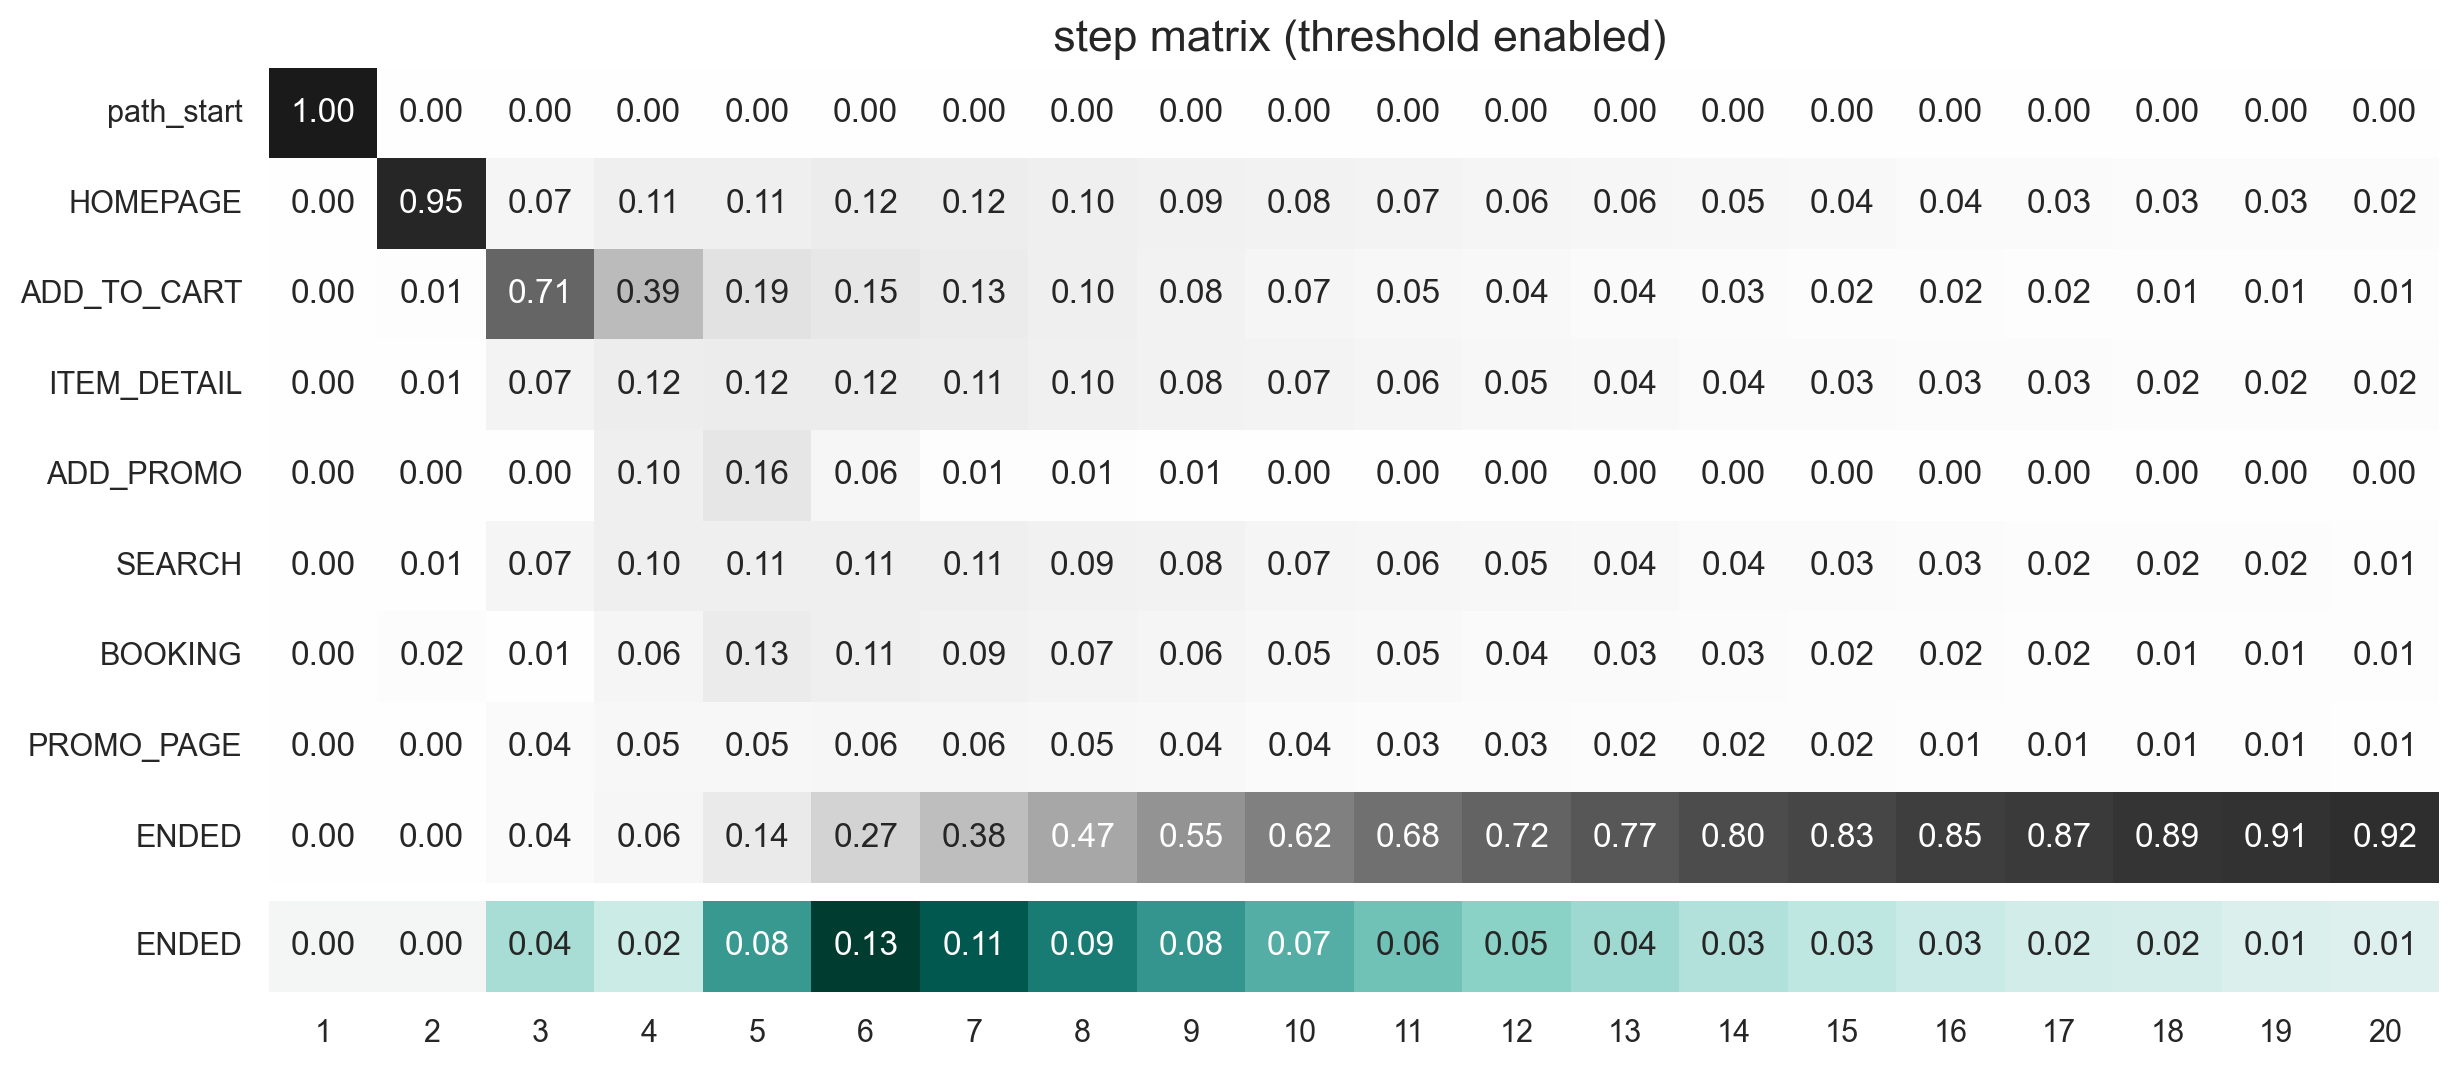

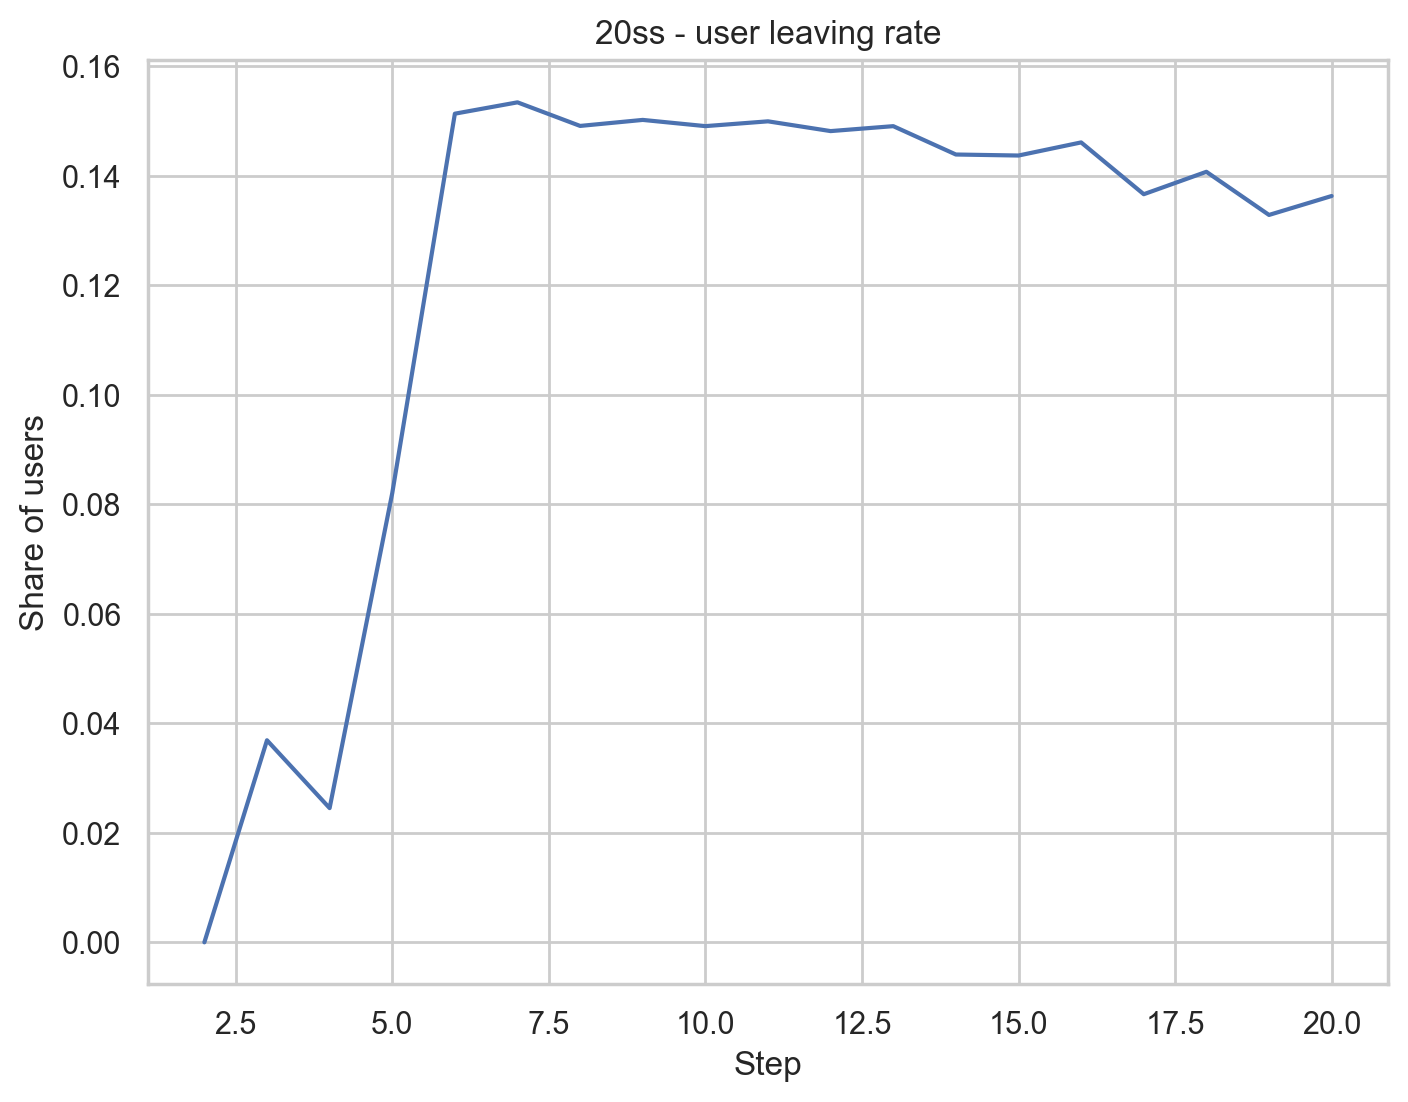

In [7]:
# 1. 처음을 기준으로 단계별 이탈률과 이전 단계 기준으로 이탈률을 보여주는 그래프
# 2. 이전단계를 기준으로한 단계별 이탈률 lineplot  

sm = stream_20ss.step_matrix(threshold=0.05, targets=['ENDED'])

ended_on_step = sm.values[1].loc["ENDED"]
users_on_step = 1 - sm.values[0].loc["ENDED"].shift(1)
ended_share = ended_on_step / users_on_step.dropna()

plt.figure(figsize=(8,6))
plt.plot(ended_share)
plt.title('20ss - user leaving rate')
plt.xlabel('Step')
plt.ylabel('Share of users')
plt.show()

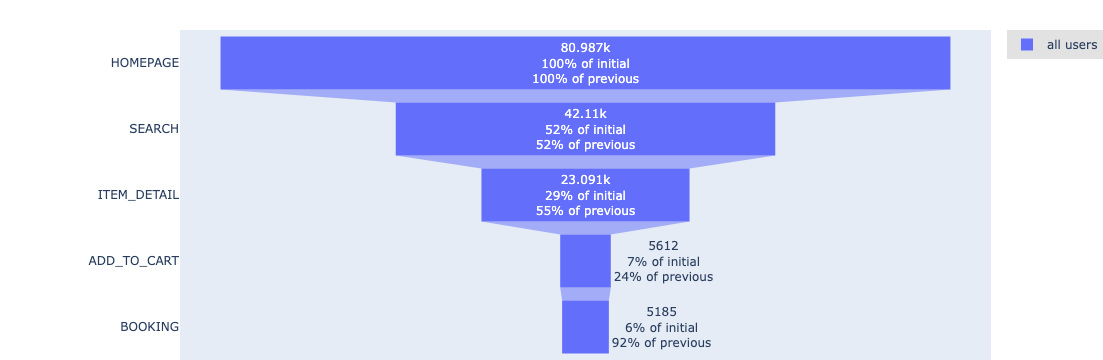

In [8]:
# HOMEPAGE - SEARCH - ITEM_DETAIL - ADD_TO_CART - BOOKING(우리가 생각하는 해피패스) funnel 그래프
# 1. 20ss 시즌 

stream_20ss.funnel(
    stages=[
            'HOMEPAGE',
            'SEARCH',
            'ITEM_DETAIL',
            'ADD_TO_CART',
            'BOOKING'
    ],
    funnel_type='closed'
)

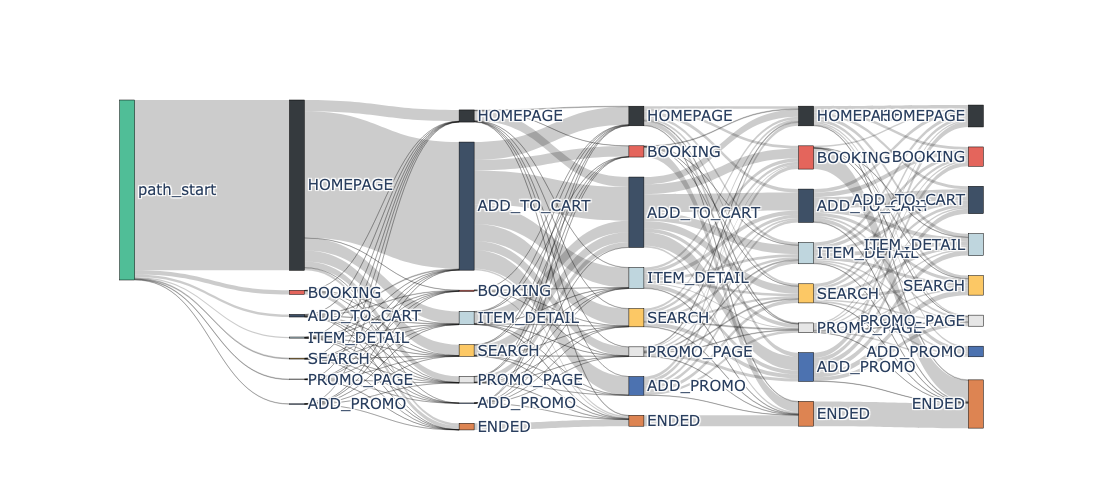

In [9]:
# Sankey Diagram로 시각화, session_id별 이동 흐름 파악
# 1. 20ss 시즌 

stream_20ss.step_sankey(
    threshold=0.02,
    width=1200,  
    height=500,  
    max_steps=6
)

In [10]:
# retentioneering으로 다루기 위해 pandas dataframe 형태의 데이터를 Eventstream이라는 형태로 변경
# raw_data_schema는 Eventstream클래스 메서드에서 요구하는 컬럼 구조를 맞추기 위해 작성

# 2. 20fw 시즌 분석

raw_data_schema = {
    'user_id': 'session_id',
    'event_name': 'event_name',
    'event_timestamp': 'event_time',
}

stream_20fw = Eventstream(df_20fw, raw_data_schema=raw_data_schema)
stream_20fw.describe()

value
category          metric                                       
overall           unique_users                           100925
                  unique_events                               9
                  eventstream_start   2020-09-01 00:00:06+00:00
                  eventstream_end     2021-02-28 23:59:44+00:00
                  eventstream_length          180 days 23:59:38
path_length_time  mean                         10 days 06:32:05
                  std                          18 days 13:48:35
                  median                        3 days 19:49:01
                  min                           0 days 00:00:00
                  max                         180 days 11:32:24
path_length_steps mean                                    11.07
                  std                                      9.01
                  median                                    9.0
                  min                                         3
                  max                                       434

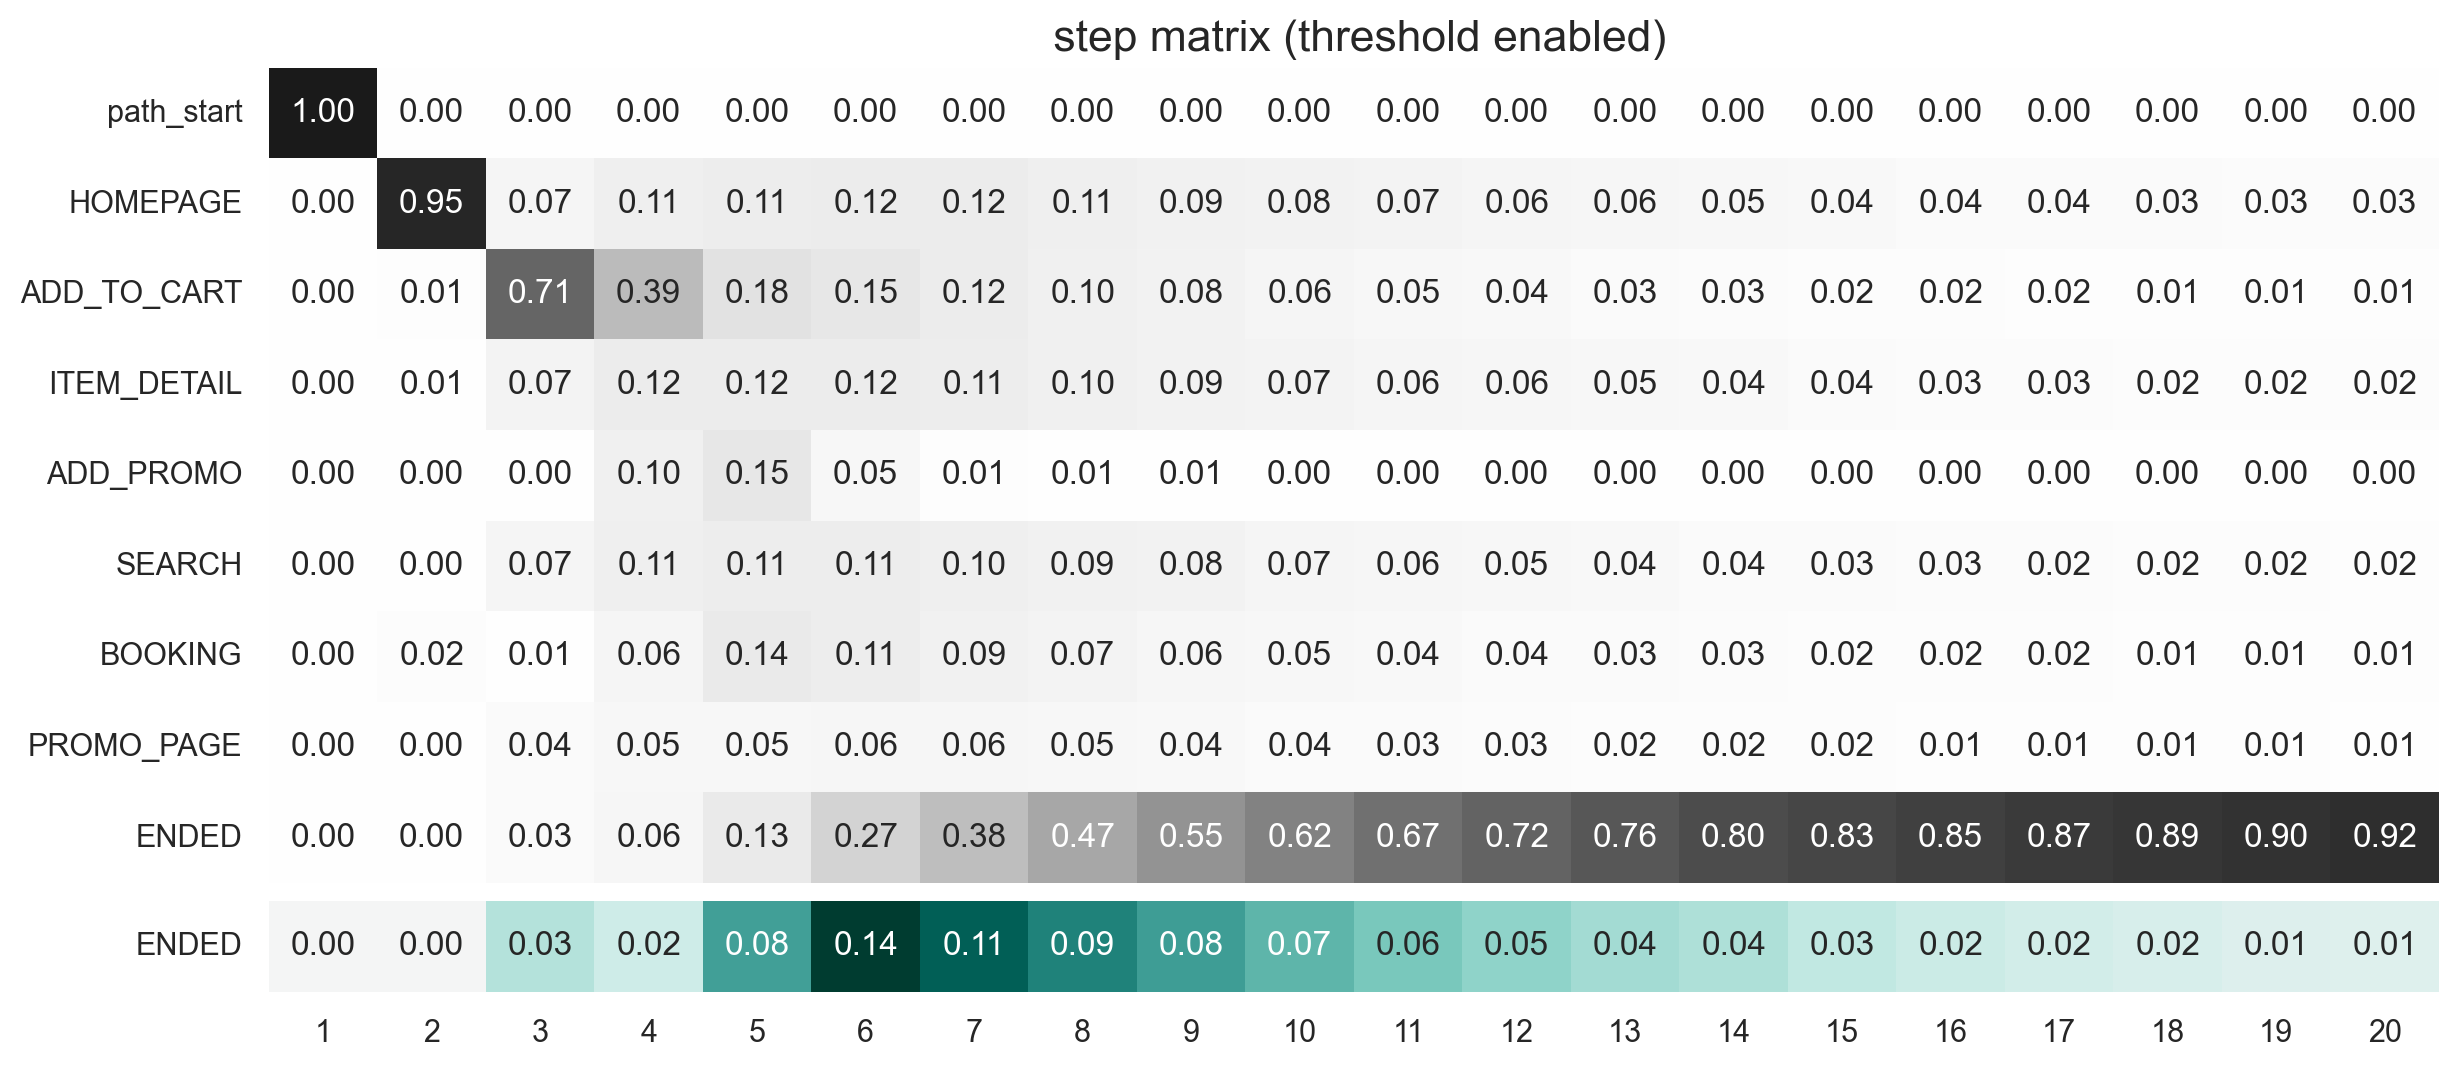

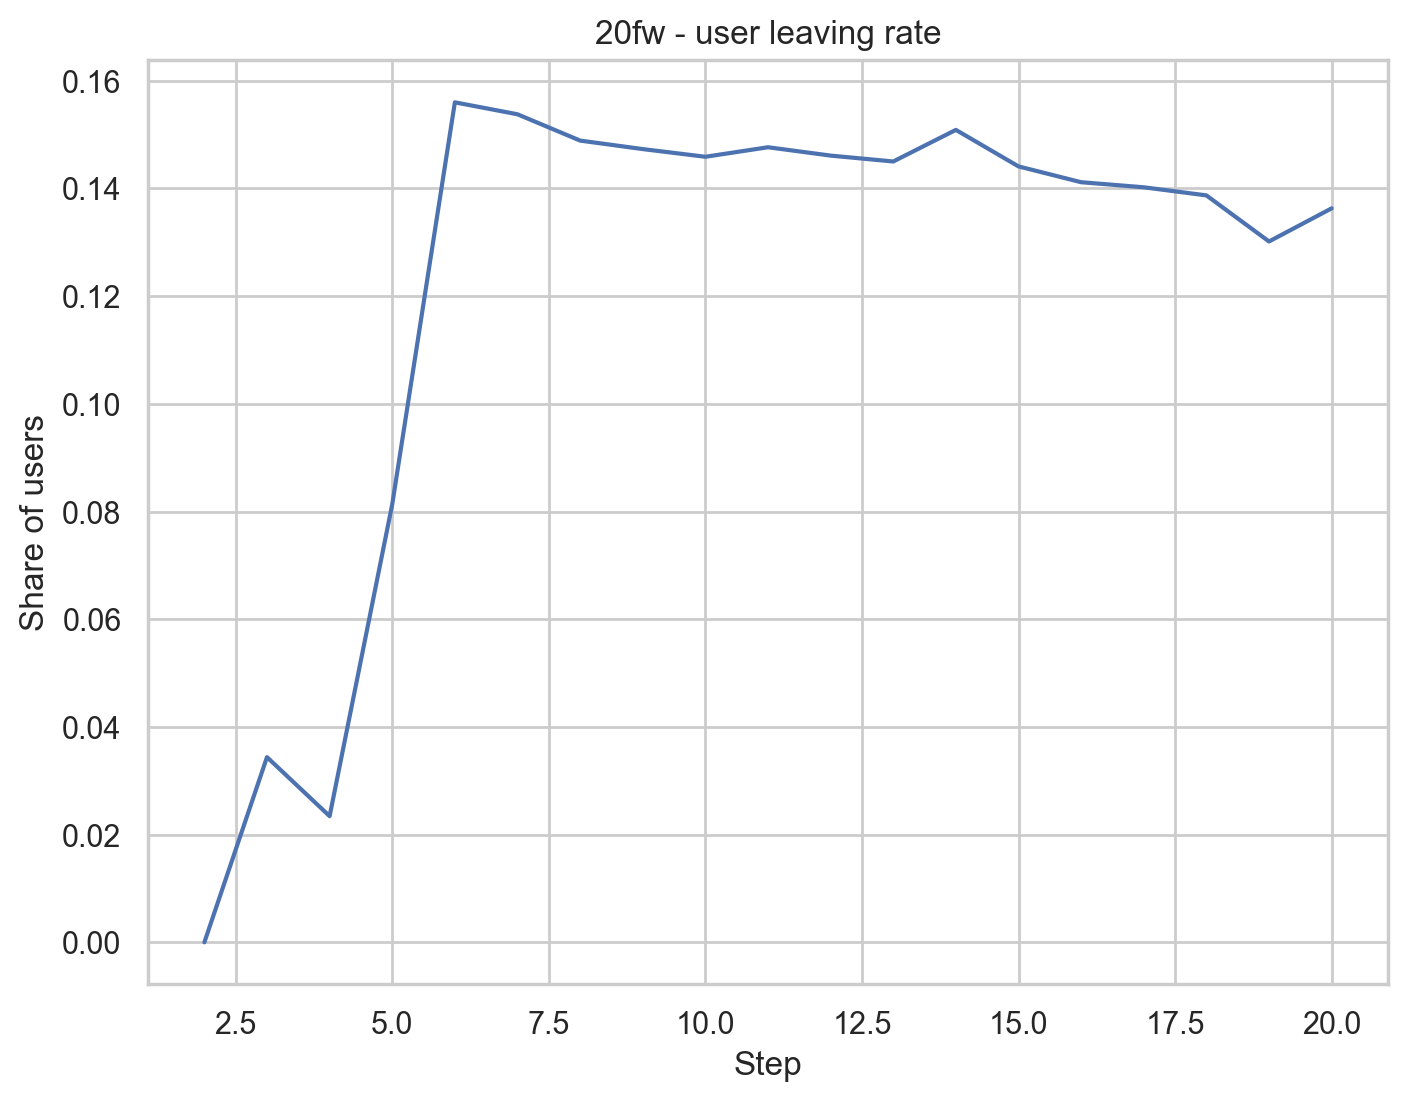

In [11]:
# 1. 처음을 기준으로 단계별 이탈률과 이전 단계 기준으로 이탈률을 보여주는 그래프
# 2. 이전단계를 기준으로한 단계별 이탈률 lineplot  

sm = stream_20fw.step_matrix(threshold=0.05, targets=['ENDED'])

ended_on_step = sm.values[1].loc["ENDED"]
users_on_step = 1 - sm.values[0].loc["ENDED"].shift(1)
ended_share = ended_on_step / users_on_step.dropna()

plt.figure(figsize=(8,6))
plt.plot(ended_share)
plt.title('20fw - user leaving rate')
plt.xlabel('Step')
plt.ylabel('Share of users')
plt.show()

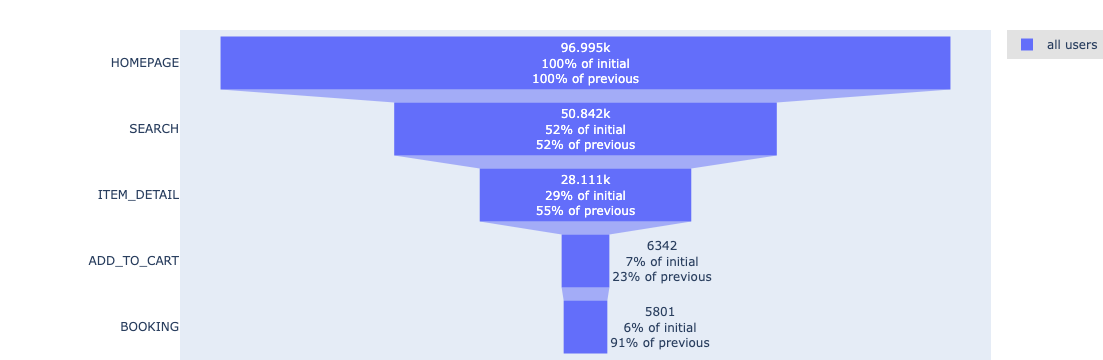

In [12]:
# HOMEPAGE - SEARCH - ITEM_DETAIL - ADD_TO_CART - BOOKING(우리가 생각하는 해피패스) funnel 그래프
# 2. 20fw 시즌 

stream_20fw.funnel(
    stages=[
            'HOMEPAGE',
            'SEARCH',
            'ITEM_DETAIL',
            'ADD_TO_CART',
            'BOOKING'
    ],
    funnel_type='closed'
)

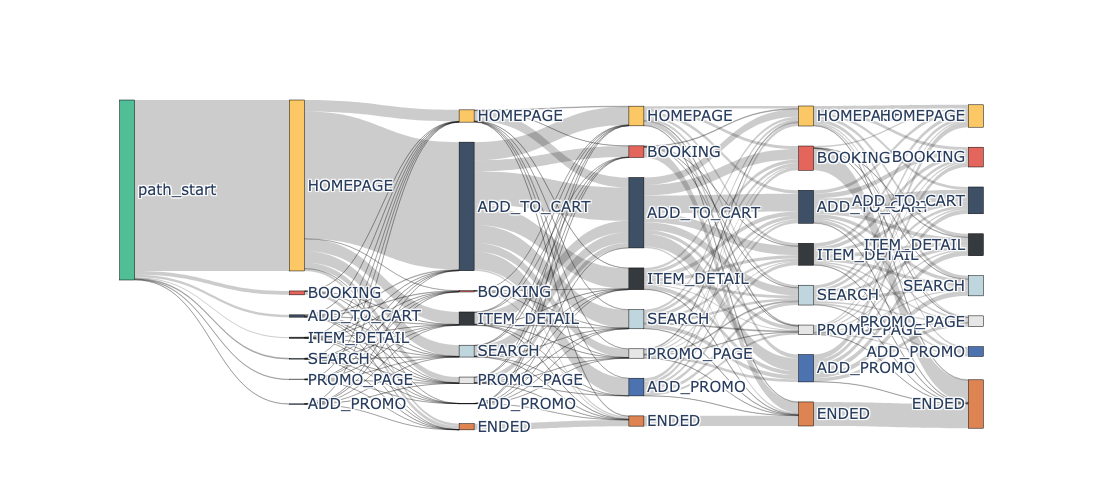

In [13]:
# Sankey Diagram로 시각화, session_id별 이동 흐름 파악
# 2. 20fw 시즌 

stream_20fw.step_sankey(
    threshold=0.02,
    width=1200,  
    height=500,  
    max_steps=6
)

In [14]:
# retentioneering으로 다루기 위해 pandas dataframe 형태의 데이터를 Eventstream이라는 형태로 변경
# raw_data_schema는 Eventstream클래스 메서드에서 요구하는 컬럼 구조를 맞추기 위해 작성

# 3. 21ss 시즌 분석

raw_data_schema = {
    'user_id': 'session_id',
    'event_name': 'event_name',
    'event_timestamp': 'event_time',
}

stream_21ss = Eventstream(df_21ss, raw_data_schema=raw_data_schema)
stream_21ss.describe()

value
category          metric                                       
overall           unique_users                           121850
                  unique_events                               9
                  eventstream_start   2021-03-01 00:00:06+00:00
                  eventstream_end     2021-08-31 23:59:57+00:00
                  eventstream_length          183 days 23:59:51
path_length_time  mean                          9 days 17:19:36
                  std                          17 days 05:20:43
                  median                        3 days 18:54:06
                  min                           0 days 00:00:00
                  max                         181 days 03:06:57
path_length_steps mean                                     11.1
                  std                                      8.94
                  median                                    9.0
                  min                                         3
                  max                                       590

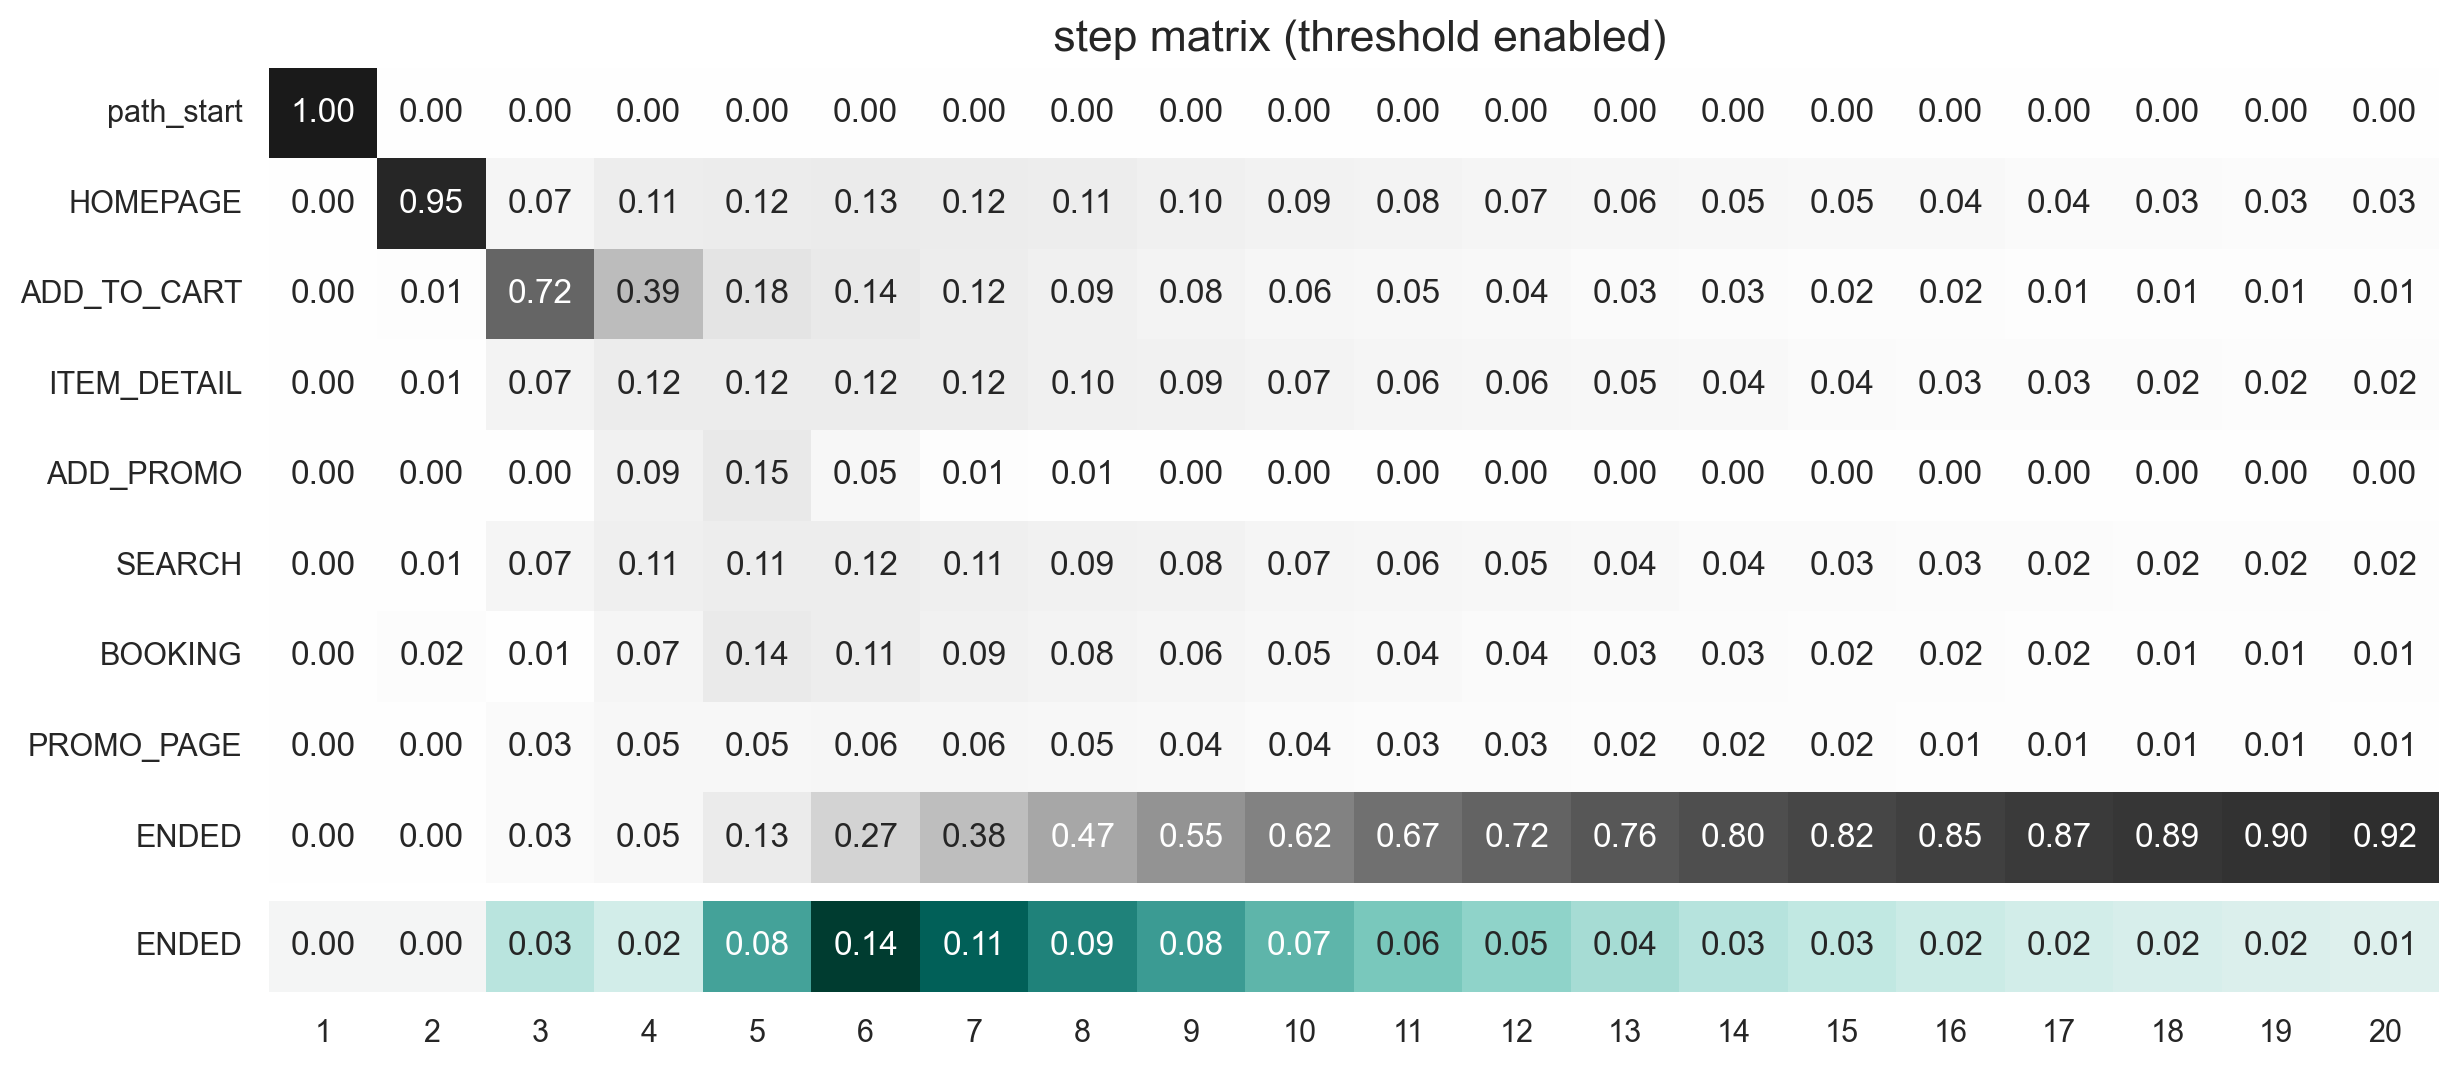

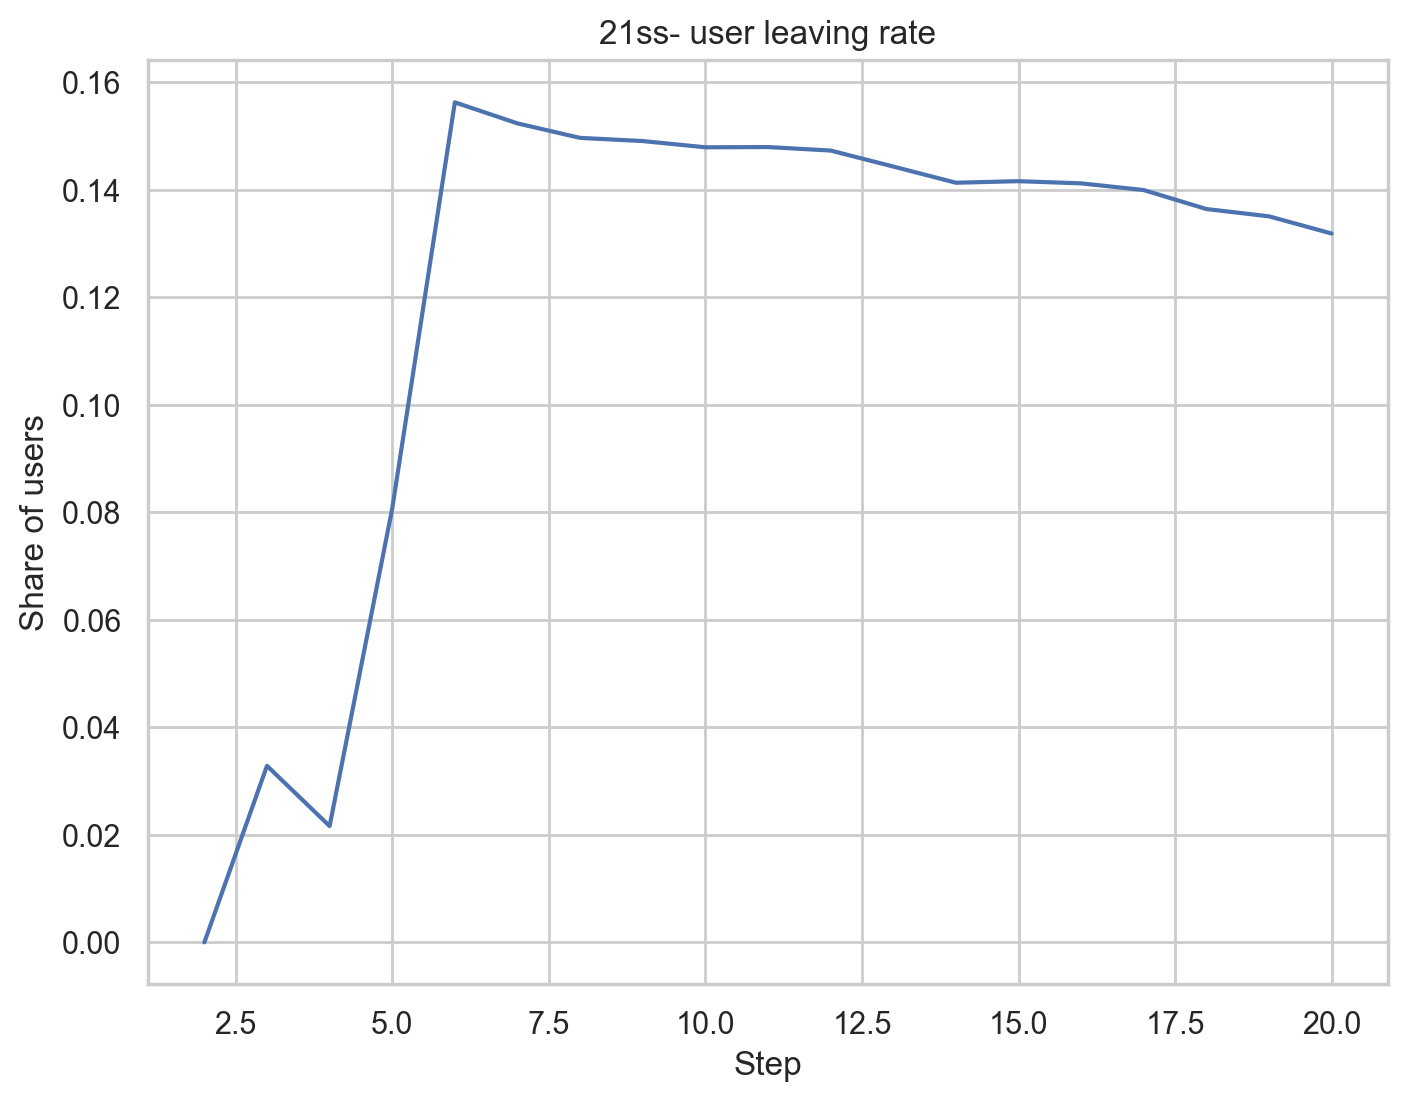

In [15]:
# 1. 처음을 기준으로 단계별 이탈률과 이전 단계 기준으로 이탈률을 보여주는 그래프
# 2. 이전단계를 기준으로한 단계별 이탈률 lineplot  

sm = stream_21ss.step_matrix(threshold=0.05, targets=['ENDED'])

ended_on_step = sm.values[1].loc["ENDED"]
users_on_step = 1 - sm.values[0].loc["ENDED"].shift(1)
ended_share = ended_on_step / users_on_step.dropna()

plt.figure(figsize=(8,6))
plt.plot(ended_share)
plt.title('21ss- user leaving rate')
plt.xlabel('Step')
plt.ylabel('Share of users')
plt.show()

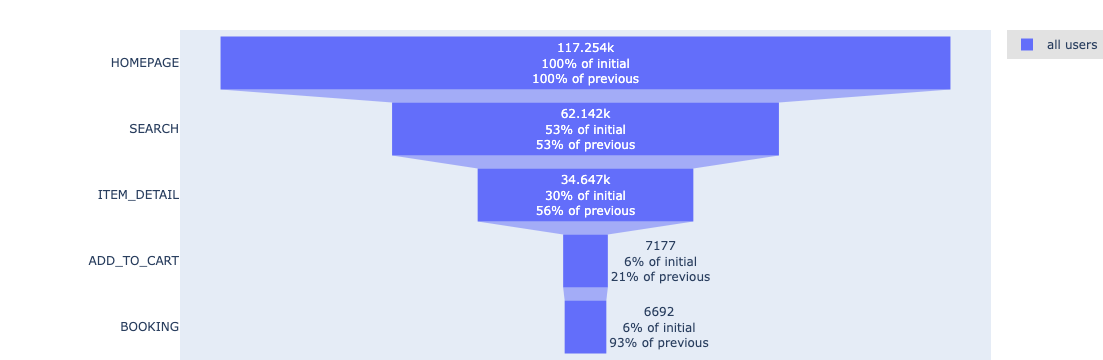

In [16]:
# HOMEPAGE - SEARCH - ITEM_DETAIL - ADD_TO_CART - BOOKING(우리가 생각하는 해피패스) funnel 그래프
# 3. 21ss 시즌 

stream_21ss.funnel(
    stages=[
            'HOMEPAGE',
            'SEARCH',
            'ITEM_DETAIL',
            'ADD_TO_CART',
            'BOOKING'
    ],
    funnel_type='closed'
)

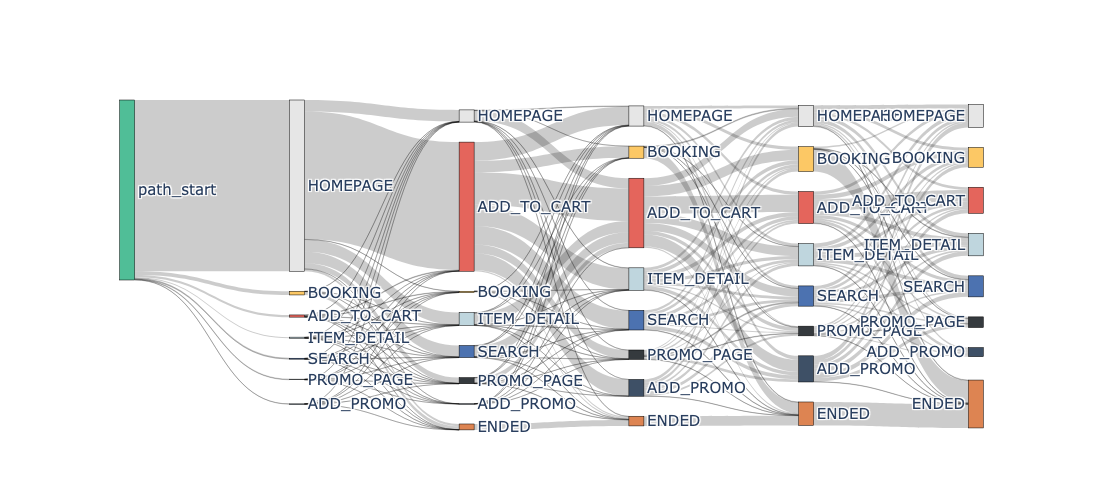

In [17]:
# Sankey Diagram로 시각화, session_id별 이동 흐름 파악
# 3. 21ss 시즌 

stream_21ss.step_sankey(
    threshold=0.02,
    width=1200,  
    height=500,  
    max_steps=6
)

In [18]:
# retentioneering으로 다루기 위해 pandas dataframe 형태의 데이터를 Eventstream이라는 형태로 변경
# raw_data_schema는 Eventstream클래스 메서드에서 요구하는 컬럼 구조를 맞추기 위해 작성

# 4. 21fw 시즌 분석

raw_data_schema = {
    'user_id': 'session_id',
    'event_name': 'event_name',
    'event_timestamp': 'event_time',
}

stream_21fw = Eventstream(df_21fw, raw_data_schema=raw_data_schema)
stream_21fw.describe()

value
category          metric                                       
overall           unique_users                           147293
                  unique_events                               9
                  eventstream_start   2021-09-01 00:00:25+00:00
                  eventstream_end     2022-02-28 23:59:50+00:00
                  eventstream_length          180 days 23:59:25
path_length_time  mean                          8 days 14:09:19
                  std                          14 days 08:30:51
                  median                        3 days 13:38:49
                  min                           0 days 00:00:00
                  max                         174 days 22:30:42
path_length_steps mean                                     11.3
                  std                                      9.03
                  median                                    9.0
                  min                                         3
                  max                                       496

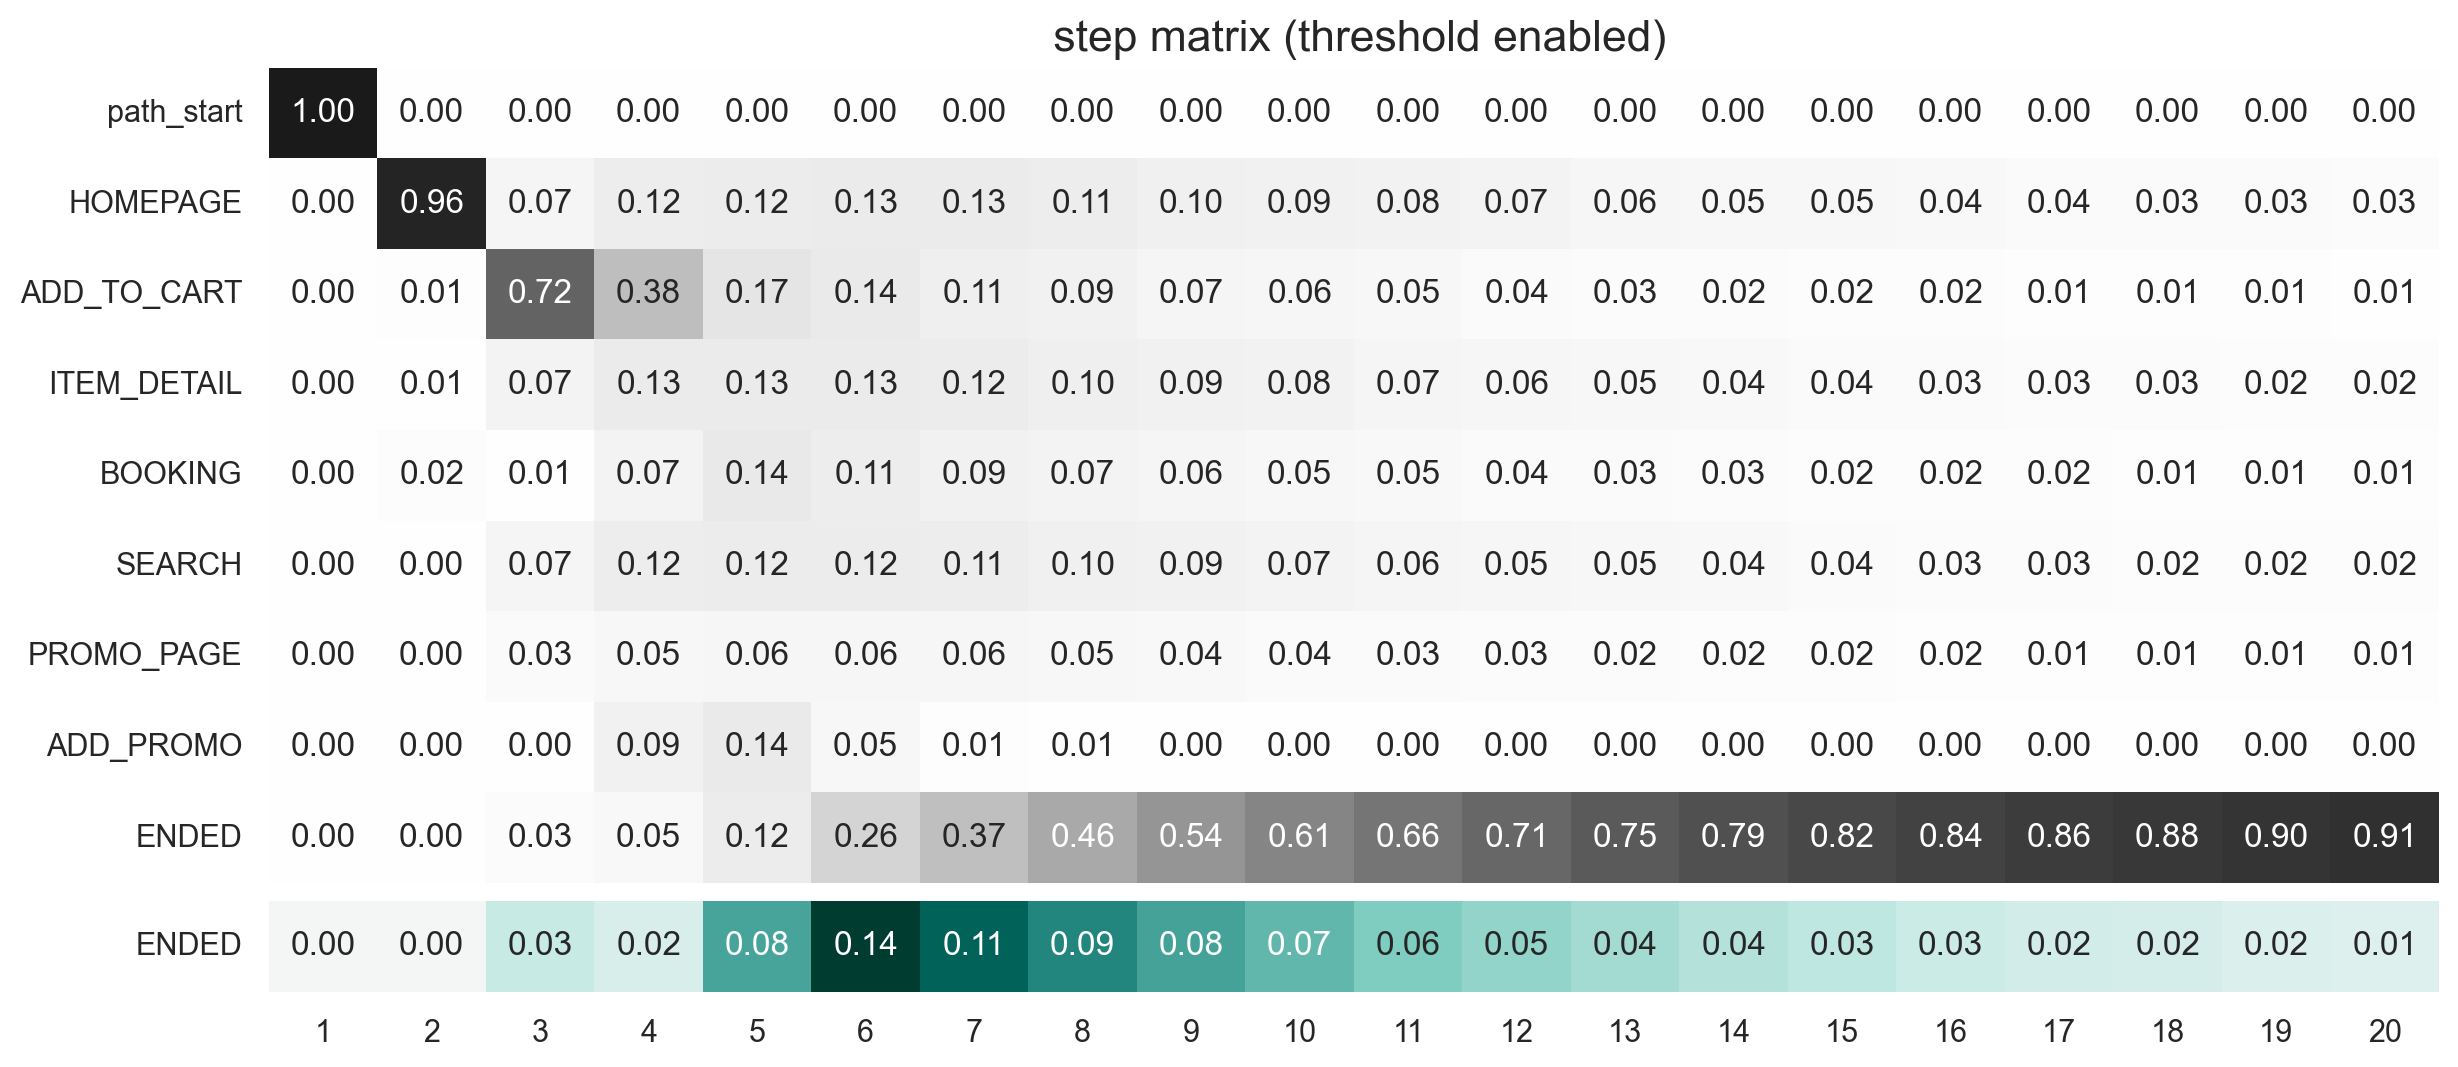

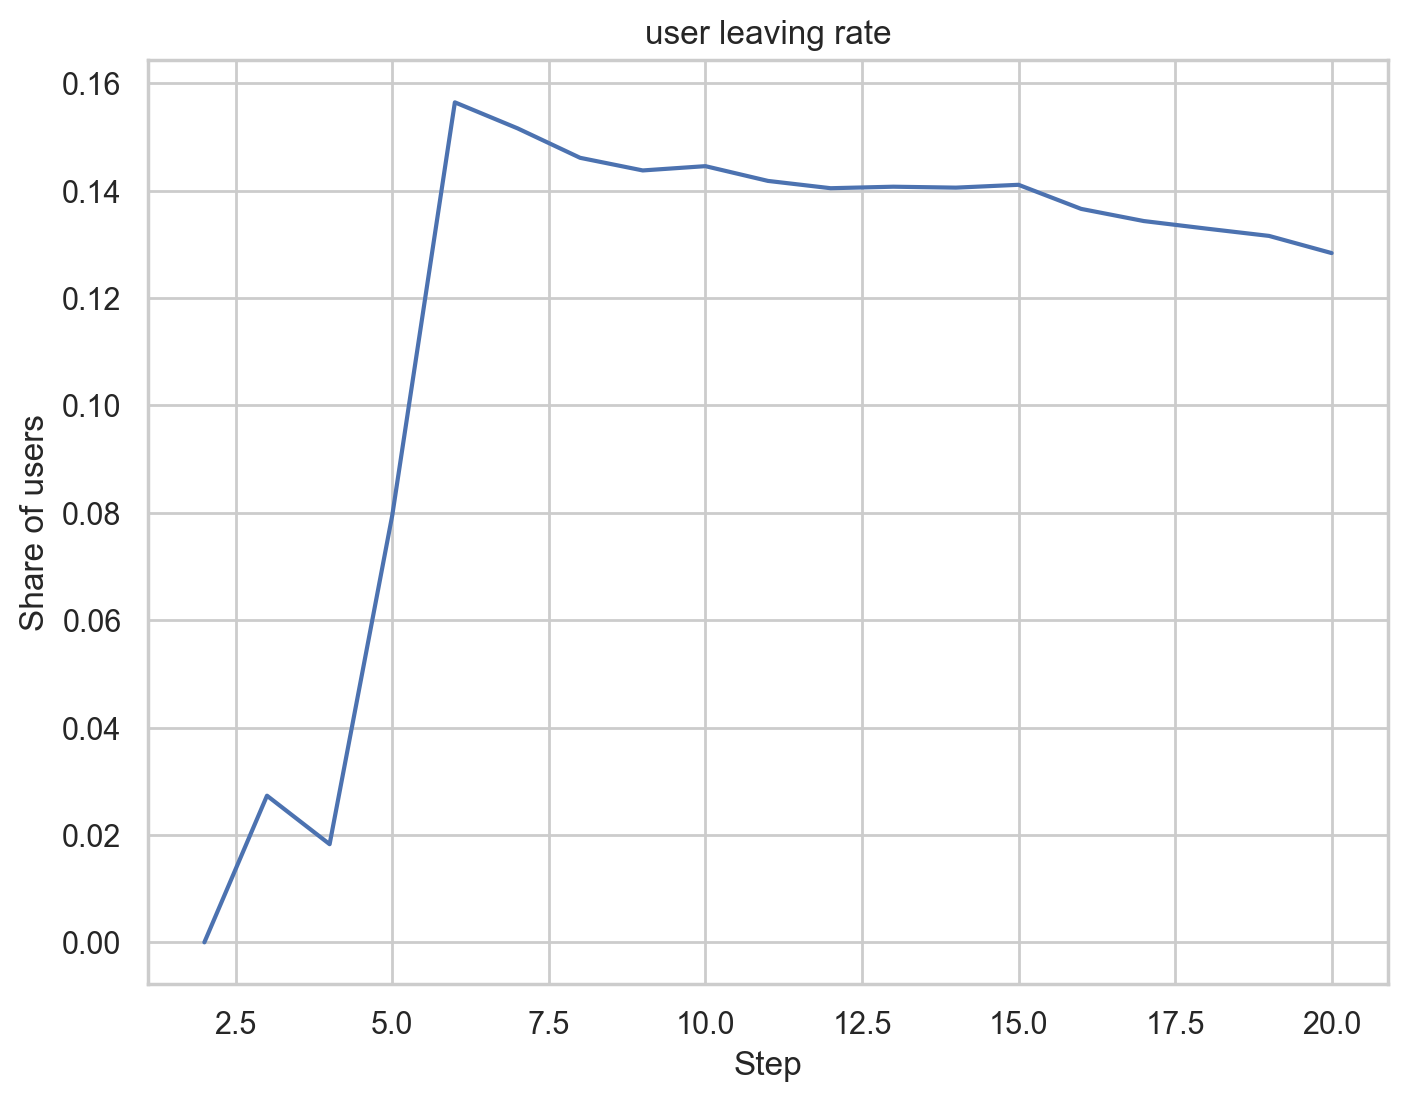

In [19]:
# 1. 처음을 기준으로 단계별 이탈률과 이전 단계 기준으로 이탈률을 보여주는 그래프
# 2. 이전단계를 기준으로한 단계별 이탈률 lineplot  

sm = stream_21fw.step_matrix(threshold=0.05, targets=['ENDED'])

ended_on_step = sm.values[1].loc["ENDED"]
users_on_step = 1 - sm.values[0].loc["ENDED"].shift(1)
ended_share = ended_on_step / users_on_step.dropna()

plt.figure(figsize=(8,6))
plt.plot(ended_share)
plt.title('user leaving rate')
plt.xlabel('Step')
plt.ylabel('Share of users')
plt.show()

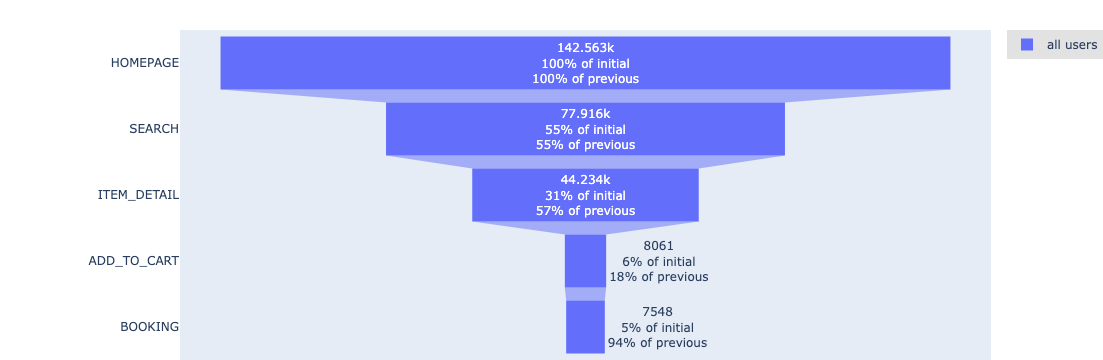

In [20]:
# HOMEPAGE - SEARCH - ITEM_DETAIL - ADD_TO_CART - BOOKING(우리가 생각하는 해피패스) funnel 그래프
# 4. 21fw 시즌 

stream_21fw.funnel(
    stages=[
            'HOMEPAGE',
            'SEARCH',
            'ITEM_DETAIL',
            'ADD_TO_CART',
            'BOOKING'
    ],
    funnel_type='closed'
)

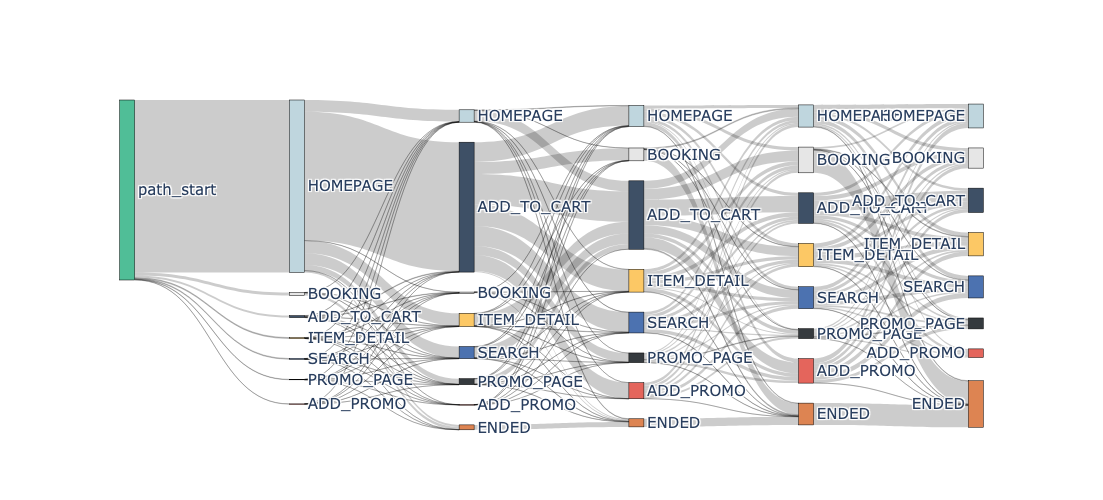

In [21]:
# Sankey Diagram로 시각화, session_id별 이동 흐름 파악
# 4. 21fw 시즌 

stream_21fw.step_sankey(
    threshold=0.02,
    width=1200,  
    height=500,  
    max_steps=6
)

In [25]:
# 5. 22ss 시즌 분석

raw_data_schema = {
    'user_id': 'session_id',
    'event_name': 'event_name',
    'event_timestamp': 'event_time',
}

stream_22ss = Eventstream(df_22ss, raw_data_schema=raw_data_schema)
stream_22ss.describe()

value
category          metric                                       
overall           unique_users                           133354
                  unique_events                               9
                  eventstream_start   2022-03-01 00:00:02+00:00
                  eventstream_end     2022-08-01 00:49:59+00:00
                  eventstream_length          153 days 00:49:57
path_length_time  mean                          5 days 14:21:08
                  std                           8 days 03:52:57
                  median                        2 days 12:19:50
                  min                           0 days 00:00:00
                  max                          88 days 05:34:56
path_length_steps mean                                    11.67
                  std                                      8.77
                  median                                    9.0
                  min                                         3
                  max                                       348

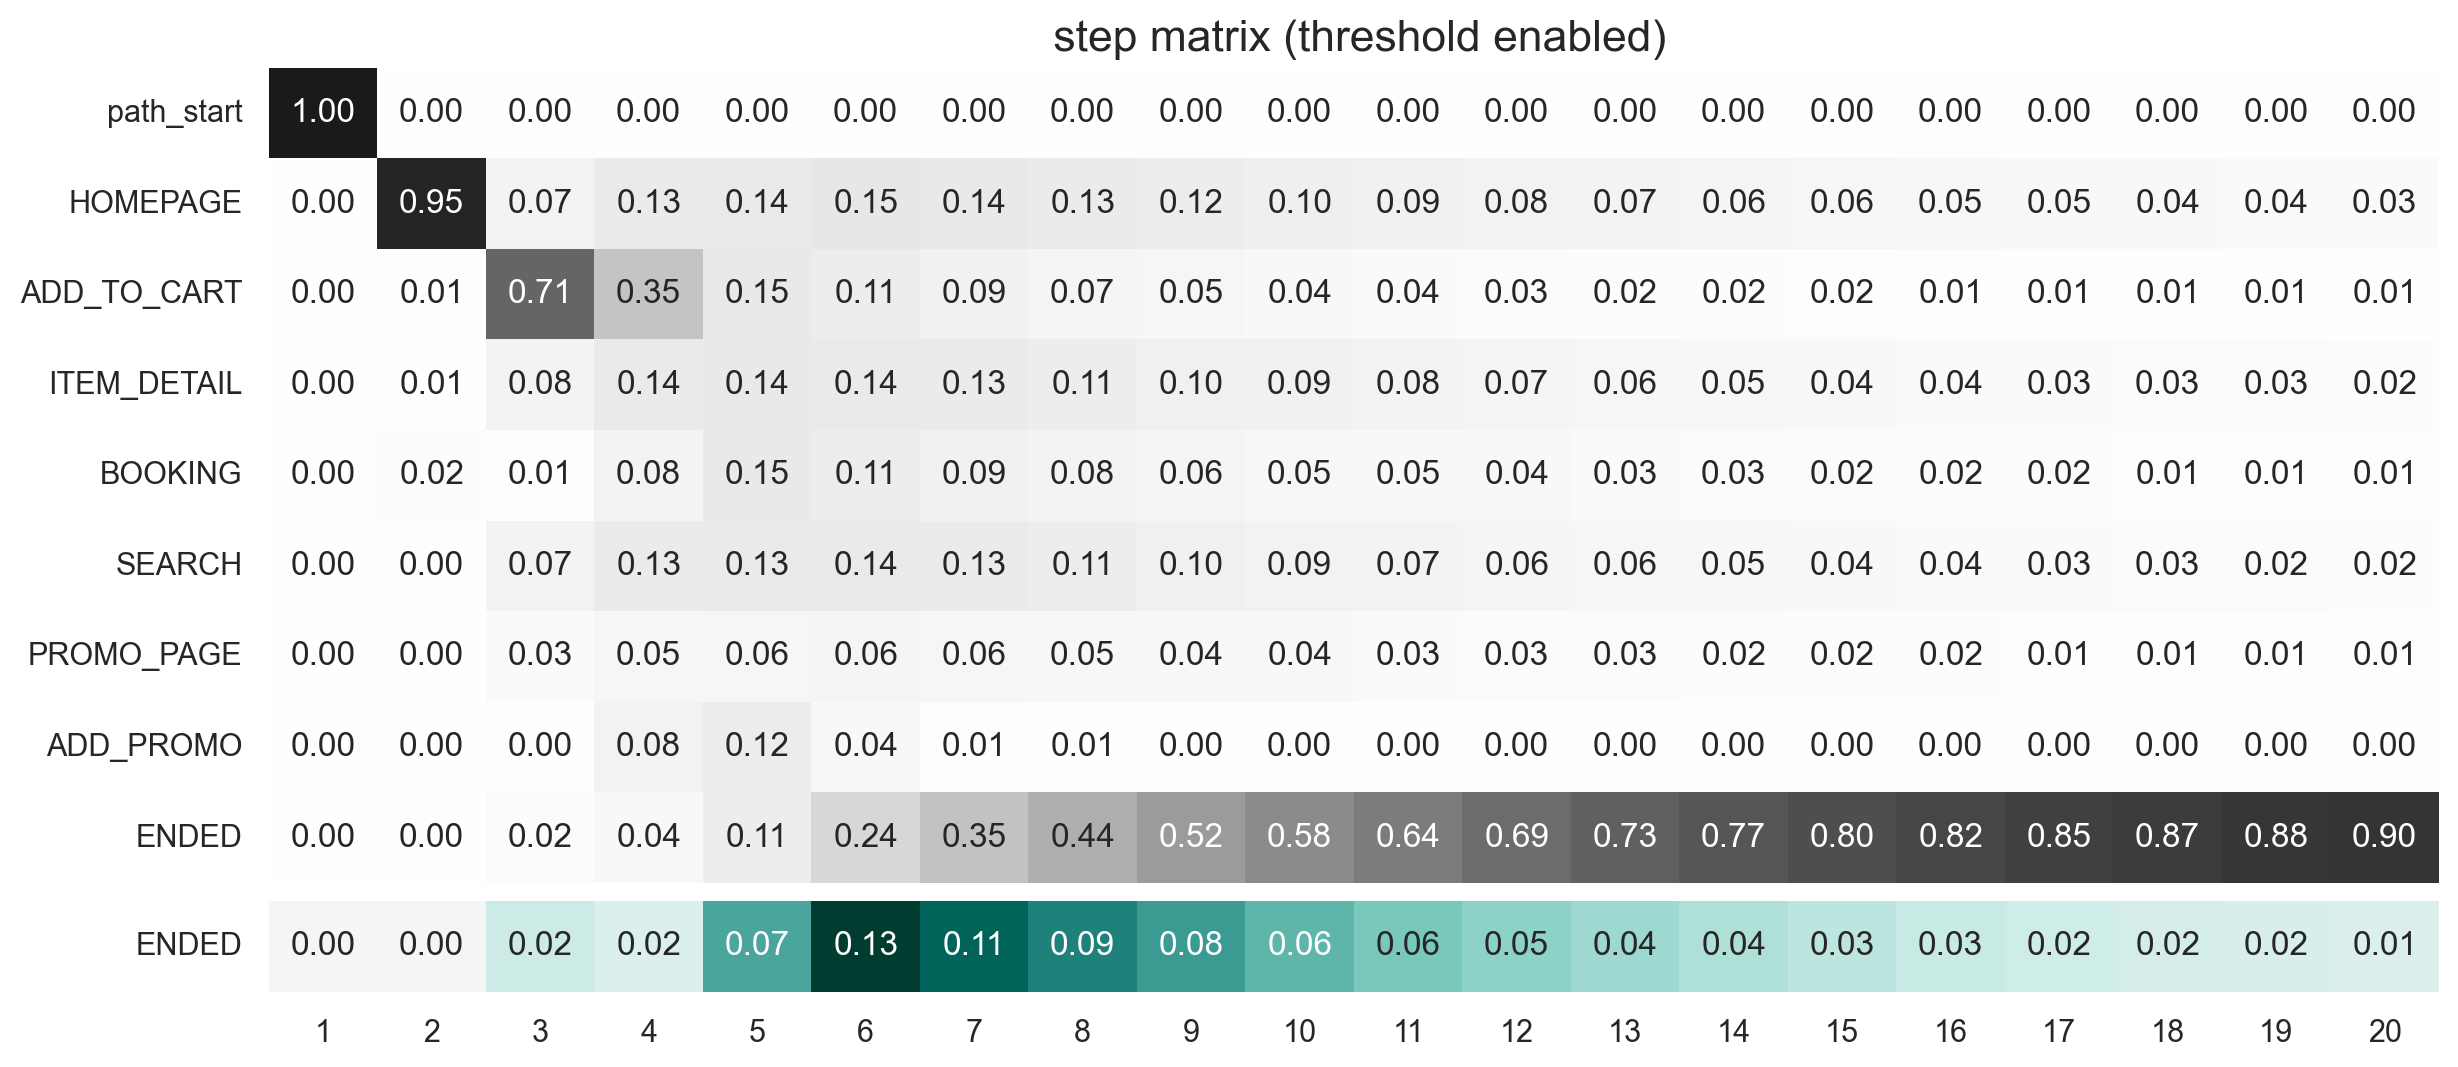

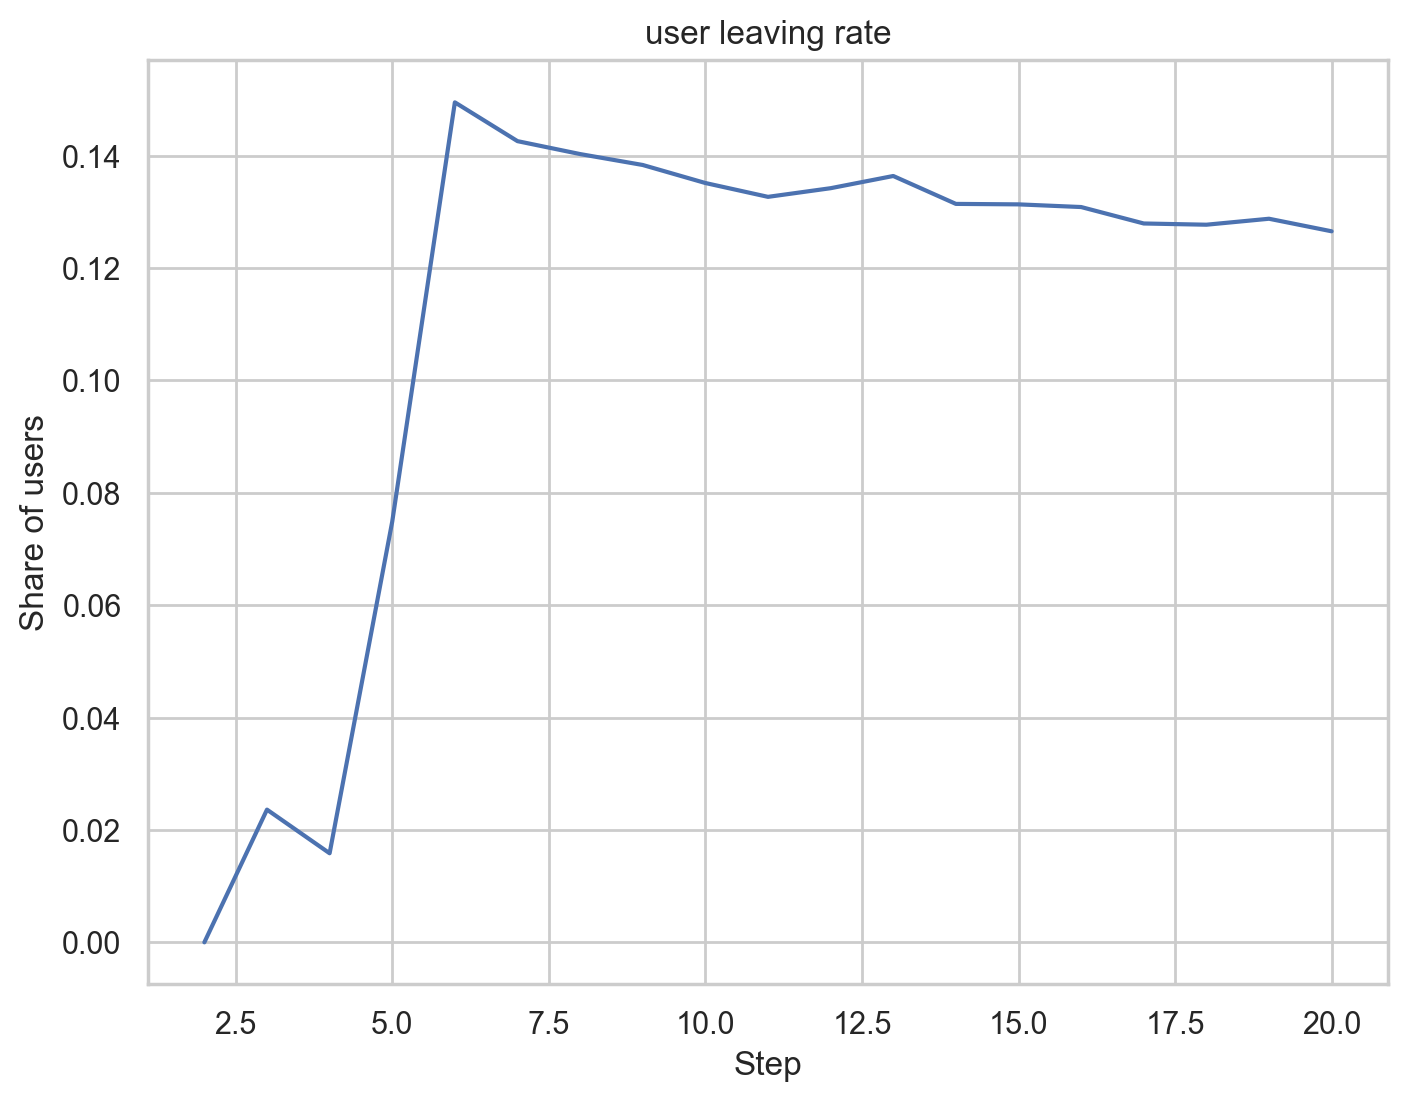

In [26]:
# 1. 처음을 기준으로 단계별 이탈률과 이전 단계 기준으로 이탈률을 보여주는 그래프
# 2. 이전단계를 기준으로한 단계별 이탈률 lineplot  

sm = stream_22ss.step_matrix(threshold=0.05, targets=['ENDED'])

ended_on_step = sm.values[1].loc["ENDED"]
users_on_step = 1 - sm.values[0].loc["ENDED"].shift(1)
ended_share = ended_on_step / users_on_step.dropna()

plt.figure(figsize=(8,6))
plt.plot(ended_share)
plt.title('user leaving rate')
plt.xlabel('Step')
plt.ylabel('Share of users')
plt.show()

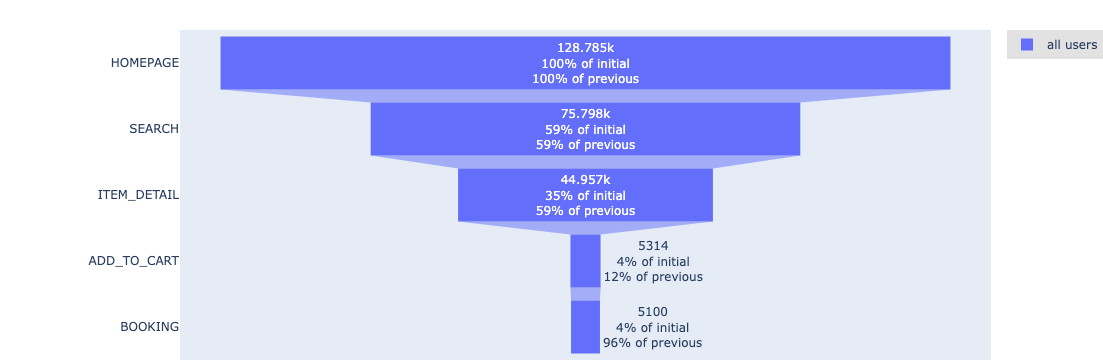

In [27]:
# HOMEPAGE - SEARCH - ITEM_DETAIL - ADD_TO_CART - BOOKING(우리가 생각하는 해피패스) funnel 그래프
# 5. 22ss 시즌 

stream_22ss.funnel(
    stages=[
            'HOMEPAGE',
            'SEARCH',
            'ITEM_DETAIL',
            'ADD_TO_CART',
            'BOOKING'
    ],
    funnel_type='closed'
)

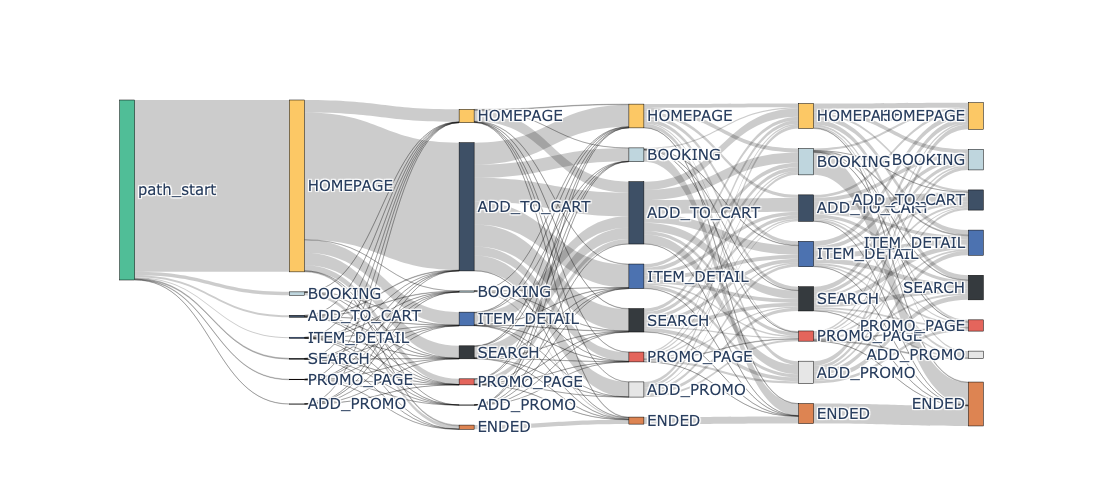

In [28]:
# Sankey Diagram로 시각화, session_id별 이동 흐름 파악
# 5. 22ss 시즌 

stream_22ss.step_sankey(
    threshold=0.02,
    width=1200,  
    height=500,  
    max_steps=6
)